In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
hparams = dict(
    # datamodule
    hdf_path='./data/ProteomeTools.hdf',
    batch_size=1024,
    train_val_split=0.9,
    cdhit_threshold=0.5,
    cdhit_word_length=3,
    cache_dir='$TMPDIR',
    num_workers=20,
    random_state=0,
    
    # model
    model_dim=512,
    model_depth=4,
    num_heads=4,
    lr=1e-4,
    dropout=0.1, 
    max_length=100,
    use_cls_token=True, # this is a big structural change to the model!

    # trainer
    num_gpus=1,
    max_epochs=50,
    precision=32,
    strategy='ddp',
    
    # cluster
    num_nodes=1,
    num_cpus=20,
    conda_env='MSPretraining',
    time='0-08:00:00',
    
    # tensorboard
    login_node='login-2'
)

In [5]:
args = ' '.join([f'--{k} {v}' for k,v in hparams.items()])

slurm = f'''#!/bin/bash -l

#SBATCH --nodes={hparams['num_nodes']}
#SBATCH --gres=gpu:volta:{hparams['num_gpus']}
#SBATCH --ntasks-per-node={hparams['num_gpus']}
#SBATCH --cpus-per-task={hparams['num_cpus']}
#SBATCH --time={hparams['time']}

source activate {hparams['conda_env']}

export NCCL_DEBUG=INFO
export PYTHONFAULTHANDLER=1

srun python train.py {args}
'''

%store slurm >submit.sh

Writing 'slurm' (str) to file 'submit.sh'.


In [6]:
from src.torch_helpers import start_tensorboard

start_tensorboard(login_node=hparams['login_node'])

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
!sbatch submit.sh

Submitted batch job 15646102


In [8]:
# it would be quite cool to UMAP the peptides!

In [4]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

dm = MSDataModule(**hparams)
model = MSTransformer(**hparams)

dm.setup()
model = model.cpu()
model.eval();

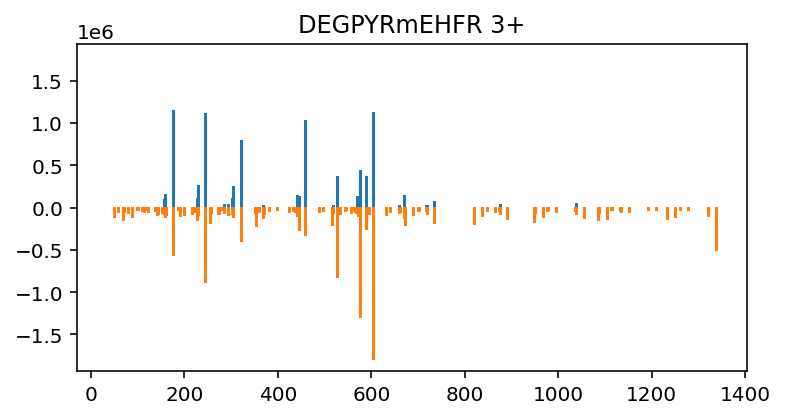

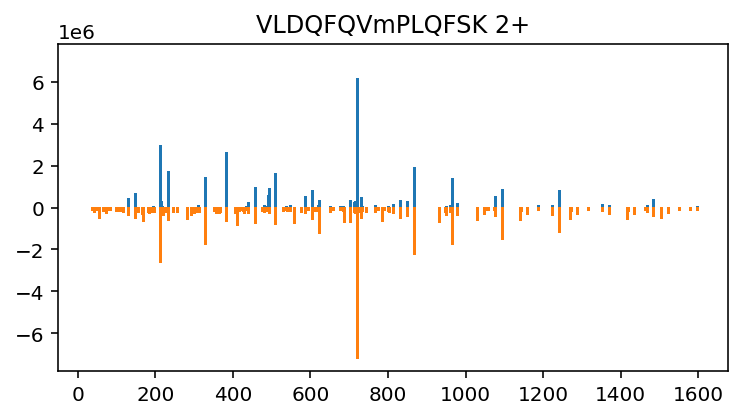

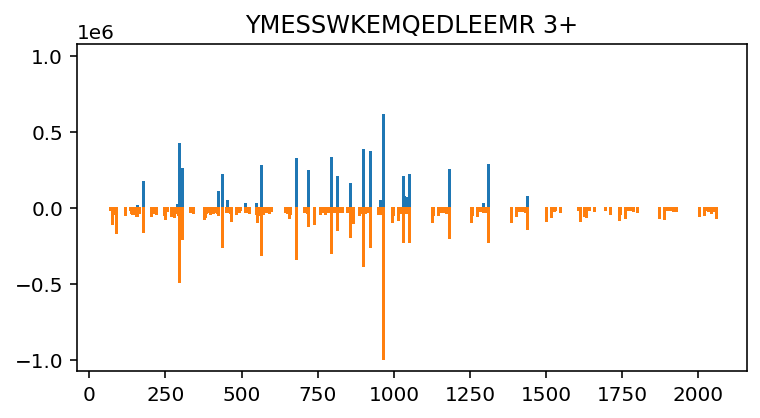

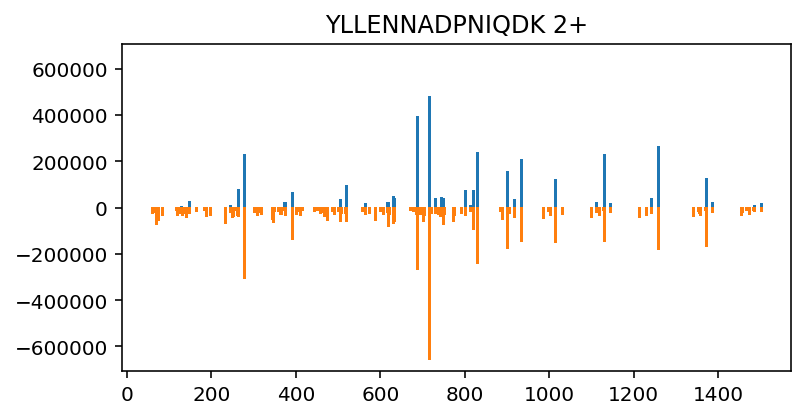

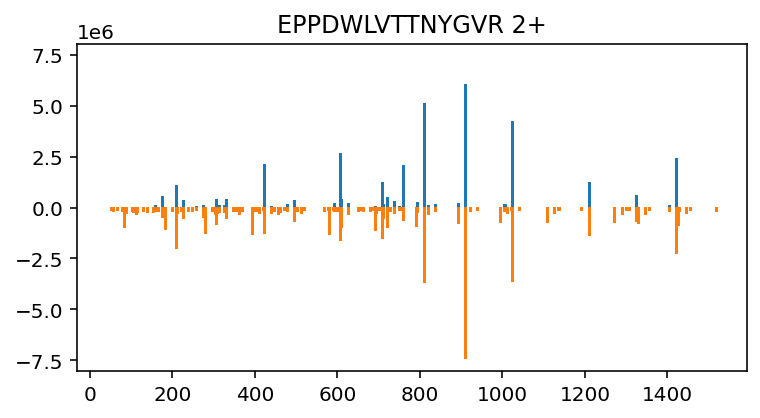

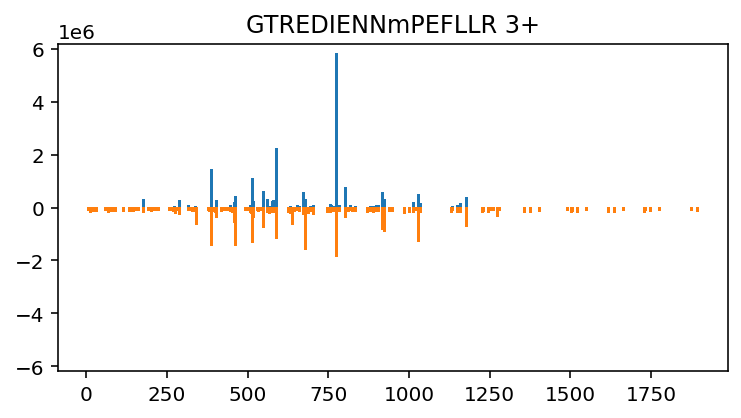

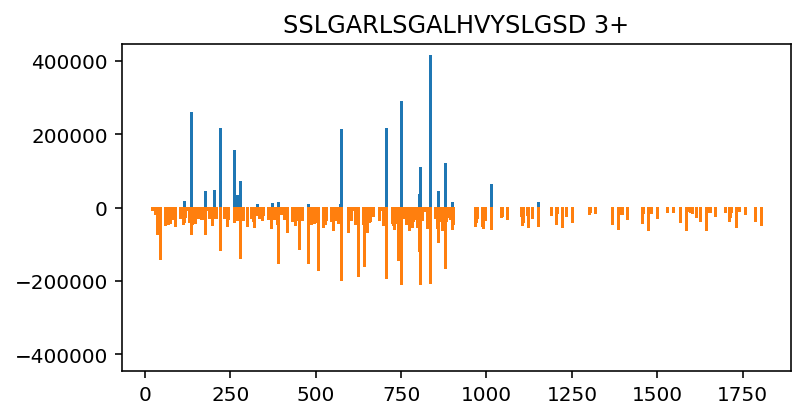

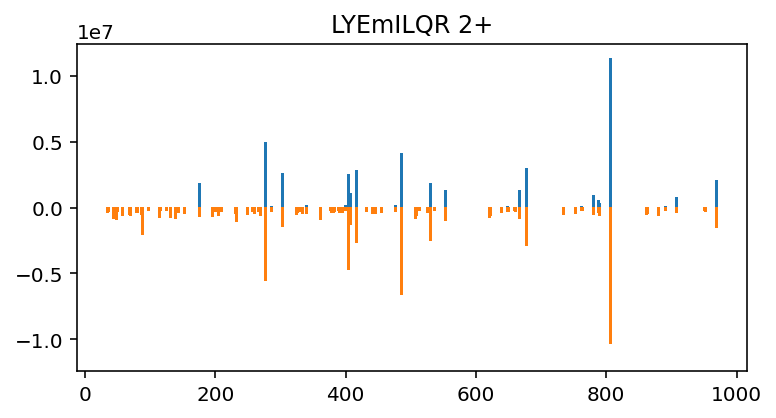

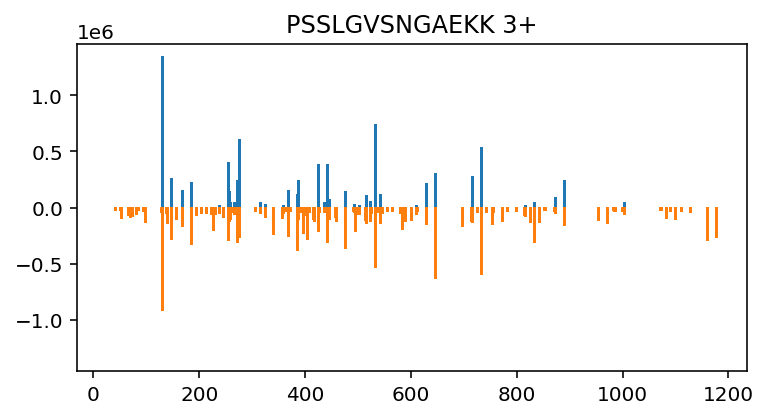

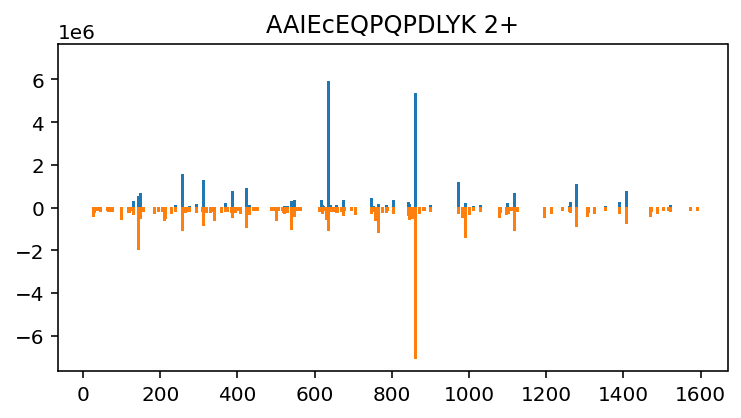

In [10]:
from src.plotting import faststem
from src.spectrum import fragment_mz_tensor

for i, batch in enumerate(dm.predict_dataloader(shuffle=True)):
    if i == 10:
        break
    
    batch['y_pred'] = model.predict_step(batch)

    mz = fragment_mz_tensor(batch['sequence'][0]).ravel()
    y = batch['y'][0].detach().cpu().numpy().ravel()
    y_pred = batch['y_pred'][0].detach().cpu().numpy().ravel()
    
    plt.figure(figsize=(6,3))
    faststem(mz,y)
    faststem(mz,-y_pred)
    yl = max(np.abs(plt.ylim()))
    plt.ylim([-yl,yl])
    plt.title(f"{batch['sequence'][0]} {batch['charge'][0]}+")